# 3rd Model training : AUTOENCODER
In this notebook we train an autoencoder to denoise our BCPPMCHURN data and feed its embeddings to an xgboost model

In [132]:
#Change working directory to project direcgtory
import os

current_directory = os.getcwd()
project_name = 'bcppmchurn'
project_path = os.path.join(current_directory.split(project_name)[0], project_name)
os.chdir(project_path)
print(os.getcwd())  

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import os
from datetime import datetime 
import random
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, confusion_matrix
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import xgboost as xgb
import torch
from sklearn.manifold import TSNE


from src.logger import logging
from src.logger_class import setup_logger
from src.eda import utils
from src.eda.utils import columnsFamilies

In [2]:
#Get todays's date
date_time = datetime.today().strftime("%Y-%m-%d")
#Declare paths
train_dev_test_path = "data/train_dev_test"
data_path = "data/experiments_data"
data_samples_path = "data/data_samples"
artifacts_path = "artifacts/eda"
x_y_sets_path = "data/x_y_sets"
models_path = "models/ml_models"
models_ressources_path = "models/ressources"

### Loading data 

------------------------

In [3]:
#Loading data
data_date = "2024-10-22"
x_train = pd.read_csv(f"{x_y_sets_path}/{data_date}_x_train_norm.csv", index_col = 0)
x_dev = pd.read_csv(f"{x_y_sets_path}/{data_date}_x_dev_norm.csv", index_col = 0)
x_test = pd.read_csv(f"{x_y_sets_path}/{data_date}_x_test_norm.csv", index_col = 0)
y_train = pd.read_csv(f"{x_y_sets_path}/{data_date}_y_train.csv", index_col = 0)
y_dev = pd.read_csv(f"{x_y_sets_path}/{data_date}_y_dev.csv", index_col = 0)
y_test = pd.read_csv(f"{x_y_sets_path}/{data_date}_y_test.csv", index_col = 0)

print (f"x_train shape : {x_train.shape}")
print (f"y_train shape : {y_train.shape}")
print ("------------------")
print (f"x_dev shape : {x_dev.shape}")
print (f"y_dev shape : {y_dev.shape}")
print ("------------------")
print (f"x_test shape : {x_test.shape}")
print (f"y_test shape : {y_test.shape}")

#transform y to array
y_train = y_train.values.flatten()
y_dev = y_dev.values.flatten()
y_test = y_test.values.flatten()
print ("------------------")
print (f"y_train length : {len(y_train)}")
print (f"y_dev length : {len(y_dev)}")
print (f"y_test length : {len(y_test)}")

x_train shape : (86992, 531)
y_train shape : (86992, 1)
------------------
x_dev shape : (14563, 531)
y_dev shape : (14563, 1)
------------------
x_test shape : (5839, 531)
y_test shape : (5839, 1)
------------------
y_train length : 86992
y_dev length : 14563
y_test length : 5839


---------------------------

### Build and train an autoencoder

Prepare data 

In [4]:
#Set seed 
np.random.seed(0)

In [5]:
def df_to_torch_tensor(df):
     """
     Transform a pandas dataframe to a torch tensor batch by batch
     """
     df_tensor_list = []
     for i in range(0,len(df), 50 ):
          if type(df) == pd.core.frame.DataFrame:
               tensor = torch.tensor(df[i:i+50].values, dtype=torch.float32)
          elif type(df) == np.ndarray:
               tensor = torch.tensor(df[i:i+50], dtype=torch.float32)

          df_tensor_list.append(tensor)
          if i%10000 == 0 and i>0:
               print (f"i = {i}, Processed 10000 points of data")
     df_tensor = torch.cat(df_tensor_list, dim=0)
     return df_tensor

In [6]:
#transform data to a pytorch tensor 
x_train_tensor = df_to_torch_tensor(x_train)
x_dev_tensor = df_to_torch_tensor(x_dev)
x_test_tensor = df_to_torch_tensor(x_test)

y_train_tensor = df_to_torch_tensor(y_train)
y_dev_tensor = df_to_torch_tensor(y_dev)
y_test_tensor = df_to_torch_tensor(y_test)

i = 10000, Processed 10000 points of data
i = 20000, Processed 10000 points of data
i = 30000, Processed 10000 points of data
i = 40000, Processed 10000 points of data
i = 50000, Processed 10000 points of data
i = 60000, Processed 10000 points of data
i = 70000, Processed 10000 points of data
i = 80000, Processed 10000 points of data
i = 10000, Processed 10000 points of data
i = 10000, Processed 10000 points of data
i = 20000, Processed 10000 points of data
i = 30000, Processed 10000 points of data
i = 40000, Processed 10000 points of data
i = 50000, Processed 10000 points of data
i = 60000, Processed 10000 points of data
i = 70000, Processed 10000 points of data
i = 80000, Processed 10000 points of data
i = 10000, Processed 10000 points of data


In [8]:
def add_noise(df):
    """
    Add a guassian noise to df 
    Parameters
    ---------
    df: torch tensor
    """
    guassian_noise = torch.randn(df.shape)
    list_of_tensors = []
    for i in range(0, len(df), 50):
        if i+50 <= len(df):
            sum_tensors =  df[i:i+50] + 0.5*guassian_noise[i:i+50]
            list_of_tensors.append(sum_tensors)
        else:
            sum_tensors =  df[i:len(df)] + 0.5*guassian_noise[i:len(df)]
            list_of_tensors.append(sum_tensors)           
    df_tensor_noise = torch.cat(list_of_tensors, dim = 0)
    return df_tensor_noise

In [9]:
#add some guassian noise to data 
x_train_tensor_noise = add_noise(x_train_tensor)
x_dev_tensor_noise = add_noise(x_dev_tensor)
x_test_tensor_noise = add_noise(x_test_tensor)

In [7]:
print (x_train_tensor.shape)

torch.Size([86992, 531])


Build the autoencoder

In [67]:
device = torch.device ("mps" if torch.backends.mps.is_available() else "cpu")
x_train_tensor, x_dev_tensor, x_test_tensor = x_train_tensor.to(device), x_dev_tensor.to(device), x_test_tensor.to(device)

In [137]:
#Build model
class Autoencoder(torch.nn.Module):
    def __init__(self, input_shape, bottelneck_shape):
        super(Autoencoder, self).__init__()
        self.input_shape = input_shape
        #Multihead attention
        #self.attention = torch.nn.MultiheadAttention(embed_dim=input_shape[1], num_heads=3, batch_first=False )

        #Encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_shape[1], input_shape[1]//2),
            torch.nn.ReLU(),
            torch.nn.Linear(input_shape[1]//2, input_shape[1]//4),
            torch.nn.ReLU(),
            torch.nn.Linear(input_shape[1]//4, bottelneck_shape), 
            torch.nn.ReLU()
            )

        #Decoder
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(bottelneck_shape, input_shape[1]//4),
            torch.nn.ReLU(),
            torch.nn.Linear(input_shape[1]//4, input_shape[1]//2),
            torch.nn.ReLU(),
            torch.nn.Linear(input_shape[1]//2, input_shape[1]),
        )
    
    def forward(self, x):
        #attention_output, _ = self.attention(x, x, x)
        encoding = self.encoder(x)
        output = self.decoder(encoding)
        return output 
    
class LargeAutoencoder(torch.nn.Module):
    def __init__(self, input_shape):
        super(LargeAutoencoder, self).__init__()
        self.input_shape = input_shape

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_shape[1], 3*input_shape[1]//4),
            torch.nn.ReLU(),
            torch.nn.Linear(3*input_shape[1]//4, input_shape[1]//2), 
            torch.nn.ReLU(),
            torch.nn.Linear(input_shape[1]//2, input_shape[1]//4),
            torch.nn.ReLU(),
            torch.nn.Linear(input_shape[1]//4, input_shape[1]//5),
            torch.nn.ReLU(),
            torch.nn.Linear(input_shape[1]//5, 50),
            torch.nn.ReLU()
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(50, input_shape[1]//5),
            torch.nn.ReLU(),
            torch.nn.Linear(input_shape[1]//5, input_shape[1]//4),
            torch.nn.ReLU(),
            torch.nn.Linear(input_shape[1]//4, input_shape[1]//2),
            torch.nn.ReLU(),
            torch.nn.Linear(input_shape[1]//2, 3*input_shape[1]//4), 
            torch.nn.ReLU(),
            torch.nn.Linear(3*input_shape[1]//4, input_shape[1]),
        )
    
    def forward(self, x):
        x_encoded = self.encoder(x)
        x_decoded = self.decoder(x_encoded)
        return x_decoded
        

In [139]:
def train_autoencoder (AUTOENCODER, x_train_tensor, x_dev_tensor, num_epochs):
    #MODEL LOSS AND OPTIMIZER
    eval_hist = {'train_loss': [], 'dev_loss':[]}
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(AUTOENCODER.parameters(), lr=0.01)

    total_params = sum(p.numel() for p in AUTOENCODER.parameters())
    trainable_params = sum(p.numel() for p in AUTOENCODER.parameters())
    print(f"Total parameters for autoencoder is: {total_params}")
    print(f"Trainable parameters: for autoencoder is {trainable_params}")

    #Pass the autoencoder and data to GPUs
    AUTOENCODER.to(device)
    #Training for autoencoder 1
    print ("training auto-encoder ----------------------------------")
    for epoch in range(1, num_epochs+1):
        train_output = AUTOENCODER(x_train_tensor)
        train_loss = criterion(train_output, x_train_tensor)
        optimizer.zero_grad()
        train_loss.backward()
        #Optimizer
        optimizer.step()
        #DEV loss
        with torch.no_grad():
            dev_output = AUTOENCODER(x_dev_tensor)
            dev_loss = criterion(dev_output, x_dev_tensor)
        #Add loss to loss hisltory
        eval_hist["train_loss"].append(train_loss.item())
        eval_hist["dev_loss"].append(dev_loss.item())   

        #Track loss every 10 epochs 
        if (epoch)%10==0:
            print (f"epoch = [{epoch}/{num_epochs}]-------------- "
                f"train_loss : {train_loss.item():4f} ------------ "
                f"dev_loss : {dev_loss.item():4f}")
    return AUTOENCODER, eval_hist

In [141]:
AUTOENCODER_1 = Autoencoder(input_shape=list(x_train_tensor.shape), bottelneck_shape = 50)
AUTOENCODER_2 = Autoencoder(input_shape=list(x_train_tensor.shape), bottelneck_shape = 100)
AUTOENCODER_1, eval_hist_1 = train_autoencoder(AUTOENCODER_1, x_train_tensor, x_dev_tensor, 400)
AUTOENCODER_2, eval_hist_2 = train_autoencoder(AUTOENCODER_2, x_train_tensor, x_dev_tensor, 400)


Total parameters for autoencoder is: 365965
Trainable parameters: for autoencoder is 365965
training auto-encoder ----------------------------------
epoch = [10/400]-------------- train_loss : 15001857595654799360.000000 ------------ dev_loss : 15365497976797528064.000000
epoch = [20/400]-------------- train_loss : 2899618320875520000.000000 ------------ dev_loss : 4032108700415033344.000000
epoch = [30/400]-------------- train_loss : 2081878537949675520.000000 ------------ dev_loss : 1845572460980731904.000000
epoch = [40/400]-------------- train_loss : 1431558229489352704.000000 ------------ dev_loss : 1395569427205849088.000000
epoch = [50/400]-------------- train_loss : 1253319972923375616.000000 ------------ dev_loss : 1219699656125054976.000000
epoch = [60/400]-------------- train_loss : 1123035679052267520.000000 ------------ dev_loss : 1080587933150347264.000000
epoch = [70/400]-------------- train_loss : 970062344266711040.000000 ------------ dev_loss : 922439678169186304.0000

In [172]:
AUTOENCODER_3 = LargeAutoencoder(input_shape=list(x_train_tensor.shape))
AUTOENCODER_3, eval_hist_3 = train_autoencoder(AUTOENCODER_3, x_train_tensor, x_dev_tensor, 800)

Total parameters for autoencoder is: 744543
Trainable parameters: for autoencoder is 744543
training auto-encoder ----------------------------------
epoch = [10/800]-------------- train_loss : 14356788417289781248.000000 ------------ dev_loss : 14943083201592033280.000000
epoch = [20/800]-------------- train_loss : 7838786730810408960.000000 ------------ dev_loss : 6528797241396690944.000000
epoch = [30/800]-------------- train_loss : 2114976174407942144.000000 ------------ dev_loss : 2088871981658144768.000000
epoch = [40/800]-------------- train_loss : 1477880929245462528.000000 ------------ dev_loss : 1400834163757547520.000000
epoch = [50/800]-------------- train_loss : 1357937954550448128.000000 ------------ dev_loss : 1329610824167194624.000000
epoch = [60/800]-------------- train_loss : 1296865306307723264.000000 ------------ dev_loss : 1276246027313086464.000000
epoch = [70/800]-------------- train_loss : 1510646100875280384.000000 ------------ dev_loss : 1291137400482824192.00

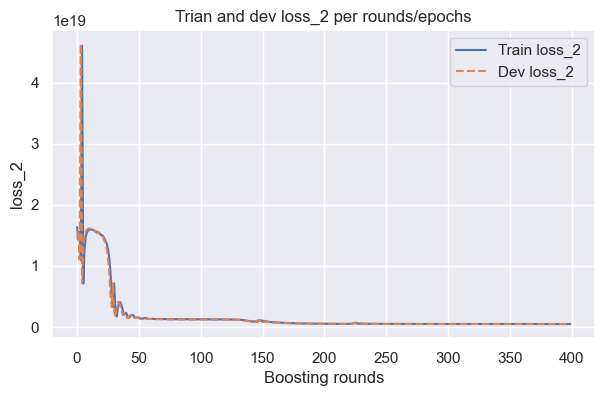

In [173]:
utils.vis_training_metric(eval_hist_1, eval_metric="loss_1")
utils.vis_training_metric(eval_hist_2, eval_metric="loss_2")
utils.vis_training_metric(eval_hist_3, eval_metric="loss_3")

The first results of training :

R2 score : -1.9627147991711744e+16

MSE : 3.389306096551199e+17

MAE : 127024152.0

In [174]:
#Test the model on test data
def evaluate_autoencoder(AUTOENCODER, x_test_tensor):
    with torch.no_grad():
        autoencoder_test_data = AUTOENCODER(x_test_tensor)
    autoencoder_test_data_numpy = autoencoder_test_data.cpu().detach().numpy()
    x_test_tensor_numpy = x_test_tensor.cpu().detach().numpy()
    mse = mean_squared_error(x_test_tensor_numpy, autoencoder_test_data_numpy)
    mae = mean_absolute_error(x_test_tensor_numpy, autoencoder_test_data_numpy)
    print (f"R2 score : {r2_score(x_test_tensor_numpy, autoencoder_test_data_numpy)}") 
    print (f"MSE : {mse}")
    print (f"MAE : {mae}") 
    return mse, mae

In [175]:
print ("AUTOENCODER 1 --------------------------")
mse_1, mae_1 = evaluate_autoencoder(AUTOENCODER_1, x_test_tensor)
print ("AUTOENCODER 2 --------------------------")
mse_2, mae_2 =evaluate_autoencoder(AUTOENCODER_2, x_test_tensor)
print ("AUTOENCODER 3 --------------------------")
mse_3, mae_3 =evaluate_autoencoder(AUTOENCODER_3, x_test_tensor)

AUTOENCODER 1 --------------------------
R2 score : -2838172102819840.0
MSE : 3.033545365488927e+17
MAE : 94125184.0
AUTOENCODER 2 --------------------------
R2 score : -1.84823717036032e+16
MSE : 4.374563004319007e+17
MAE : 126015480.0
AUTOENCODER 3 --------------------------
R2 score : -2218639444934656.0
MSE : 2.9693005574805914e+17
MAE : 92386248.0


In [176]:
#Vis MSE and MAE
list_mse = [mse_1, mse_2, mse_3]
list_mae = [mae_1, mae_2, mae_3]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (2*5, 3))
axres = axes.flatten()
axes[0].plot(list_mse, marker = "o", label = "mse", color = 'red')
axes[1].plot(list_mae, marker = "o", label = "mae")
axes[0].legend()
axes[1].legend()
axes[0].set_title("MSE of  the three encoders")
axes[1].set_title("MAE of  the three encoders")

Text(0.5, 1.0, 'MAE of  the three encoders')

Extract unoised data from original data

In [177]:
#Unoise data and transform it to numpy
#columns = [f"x{i}" for i in range(1, 11)]
def encode_data(AUTOENCODER, x_train_tensor, x_dev_tensor, x_test_tensor):
    with torch.no_grad():
        encoded_train_data = AUTOENCODER.encoder(x_train_tensor)
        encoded_train_data = encoded_train_data.cpu().detach().numpy()
        encoded_train_data = pd.DataFrame(encoded_train_data )
        encoded_dev_data = AUTOENCODER.encoder(x_dev_tensor)
        encoded_dev_data = encoded_dev_data.cpu().detach().numpy()
        encoded_dev_data = pd.DataFrame(encoded_dev_data)
        encoded_test_data = AUTOENCODER.encoder(x_test_tensor)
        encoded_test_data = encoded_test_data.cpu().detach().numpy()
        encoded_test_data = pd.DataFrame(encoded_test_data)

    print( f"train shape : {encoded_train_data.shape}")
    print( f"dev shape : {encoded_dev_data.shape}")
    print( f"test shape : {encoded_test_data.shape}")
    return encoded_train_data, encoded_dev_data, encoded_test_data

In [178]:
encoded_train_data_1, encoded_dev_data_1, encoded_test_data_1 = encode_data(AUTOENCODER_1, x_train_tensor, x_dev_tensor, x_test_tensor)
encoded_train_data_2, encoded_dev_data_2, encoded_test_data_2 = encode_data(AUTOENCODER_2, x_train_tensor, x_dev_tensor, x_test_tensor)
encoded_train_data_3, encoded_dev_data_3, encoded_test_data_3 = encode_data(AUTOENCODER_3, x_train_tensor, x_dev_tensor, x_test_tensor)

train shape : (86992, 50)
dev shape : (14563, 50)
test shape : (5839, 50)
train shape : (86992, 100)
dev shape : (14563, 100)
test shape : (5839, 100)
train shape : (86992, 50)
dev shape : (14563, 50)
test shape : (5839, 50)


### Train XGBoost on encoder output data (encoded data)

In [179]:
def train_xgboost(encoded_train_data, encoded_dev_data, boosting_rounds = 10000 ):

    dtrain = xgb.DMatrix(data=encoded_train_data, label=y_train_tensor)
    ddev = xgb.DMatrix(data=encoded_dev_data, label=y_dev_tensor)
    evals = [(dtrain, "train"), (ddev, "dev")]
    #Parameters 
    params = {
        'learning_rate':0.001,
        'eta':0.1,
        'max_depth':7,
        'objective':'binary:logistic',
        'eval_metric':'logloss',
        'gamma':0.1,
        'subsample': 0.9,                 
        'colsample_bytree': 1,           
        'min_child_weight': 1,     
        'scale_pos_weight': 1,   
    }
    #Initialize and train model
    xgb_eval_hist = {}
    XGB_MODEL = 0
    XGB_MODEL = xgb.train(  params=params, 
                            dtrain=dtrain, 
                            num_boost_round=boosting_rounds,
                            evals=evals,
                            early_stopping_rounds=50, 
                            evals_result=xgb_eval_hist, 
                            verbose_eval=True
                        )
    return XGB_MODEL, xgb_eval_hist

In [165]:
print ("ENCODED DATA 1")
XGB_MODEL_1, xgb_eval_hist_1 = train_xgboost(encoded_train_data_1, encoded_dev_data_1)
print ("ENCODED DATA 2")
XGB_MODEL_2, xgb_eval_hist_2 = train_xgboost(encoded_train_data_2, encoded_dev_data_2)

ENCODED DATA 1
[0]	train-logloss:0.69279	dev-logloss:0.69280
[1]	train-logloss:0.69244	dev-logloss:0.69246
[2]	train-logloss:0.69210	dev-logloss:0.69213
[3]	train-logloss:0.69175	dev-logloss:0.69179
[4]	train-logloss:0.69141	dev-logloss:0.69146
[5]	train-logloss:0.69106	dev-logloss:0.69113
[6]	train-logloss:0.69072	dev-logloss:0.69080
[7]	train-logloss:0.69038	dev-logloss:0.69047
[8]	train-logloss:0.69003	dev-logloss:0.69014
[9]	train-logloss:0.68969	dev-logloss:0.68981
[10]	train-logloss:0.68935	dev-logloss:0.68948
[11]	train-logloss:0.68901	dev-logloss:0.68916
[12]	train-logloss:0.68868	dev-logloss:0.68883
[13]	train-logloss:0.68834	dev-logloss:0.68850
[14]	train-logloss:0.68800	dev-logloss:0.68817
[15]	train-logloss:0.68766	dev-logloss:0.68785
[16]	train-logloss:0.68733	dev-logloss:0.68753
[17]	train-logloss:0.68699	dev-logloss:0.68720
[18]	train-logloss:0.68666	dev-logloss:0.68688
[19]	train-logloss:0.68632	dev-logloss:0.68656
[20]	train-logloss:0.68599	dev-logloss:0.68624
[21]	tra

In [180]:
print ("ENCODED DATA 3")
XGB_MODEL_3, xgb_eval_hist_3 = train_xgboost(encoded_train_data_3, encoded_dev_data_3)

ENCODED DATA 3
[0]	train-logloss:0.69278	dev-logloss:0.69279
[1]	train-logloss:0.69243	dev-logloss:0.69244
[2]	train-logloss:0.69208	dev-logloss:0.69210
[3]	train-logloss:0.69173	dev-logloss:0.69176
[4]	train-logloss:0.69138	dev-logloss:0.69142
[5]	train-logloss:0.69103	dev-logloss:0.69107
[6]	train-logloss:0.69068	dev-logloss:0.69073
[7]	train-logloss:0.69033	dev-logloss:0.69039
[8]	train-logloss:0.68998	dev-logloss:0.69005
[9]	train-logloss:0.68963	dev-logloss:0.68971
[10]	train-logloss:0.68929	dev-logloss:0.68938
[11]	train-logloss:0.68894	dev-logloss:0.68904
[12]	train-logloss:0.68860	dev-logloss:0.68870
[13]	train-logloss:0.68825	dev-logloss:0.68837
[14]	train-logloss:0.68791	dev-logloss:0.68803
[15]	train-logloss:0.68757	dev-logloss:0.68770
[16]	train-logloss:0.68722	dev-logloss:0.68736
[17]	train-logloss:0.68688	dev-logloss:0.68703
[18]	train-logloss:0.68654	dev-logloss:0.68670
[19]	train-logloss:0.68620	dev-logloss:0.68637
[20]	train-logloss:0.68586	dev-logloss:0.68604
[21]	tra

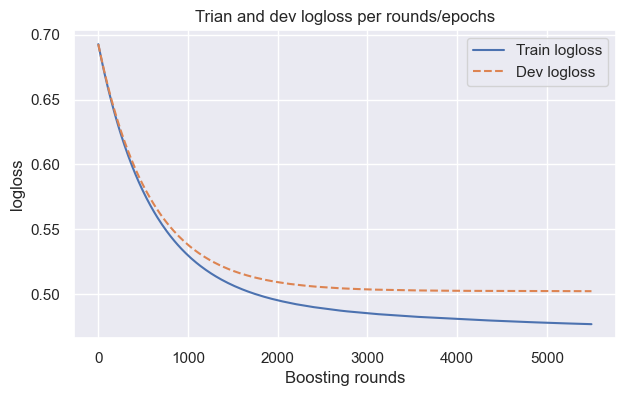

In [181]:
#Plot eval metric
utils.vis_training_metric(xgb_eval_hist_1, eval_metric="logloss")
utils.vis_training_metric(xgb_eval_hist_2, eval_metric="logloss")
utils.vis_training_metric(xgb_eval_hist_3, eval_metric="logloss")

In [182]:
def evaluate_xgboost(XGB_MODEL,encoded_train_data, encoded_test_data,y_train_tensor, y_test_tensor):
    dtrain = xgb.DMatrix(data=encoded_train_data, label=y_train_tensor)
    #Predictions
    dtest = xgb.DMatrix(data=encoded_test_data, label=y_test_tensor)
    y_test_predicted_prob = XGB_MODEL.predict(dtest)
    y_train_predicted_prob = XGB_MODEL.predict(dtrain)
    #Transform probas into predictions
    THRESHOLD = 0.5
    y_test_pred = [int(y_test_predicted_prob[i]>THRESHOLD) for i in range(len(y_test_predicted_prob))]
    y_train_pred = [int(y_train_predicted_prob[i]>THRESHOLD) for i in range(len(y_train_predicted_prob))]

    #Visualize model performance
    utils.report_model_performances(y_train, y_train_pred, y_test, y_test_pred, model_name = "xgboost")

    #Plot roc curve 
    utils.vis_roc_curve(y_test, y_test_predicted_prob)
    return y_test_pred

AUTOENCODE 1
                  train set      ||     test set
------------------------------------------------------------
xgboost accuracy    : 0.7889920912267795  ||  0.7742764171947252
xgboost precision   : 0.8488218454085004  ||  0.8369384359400999
xgboost recall      : 0.705629290617849  ||  0.6848196051735874
xgboost f1 score    : 0.7706302794022092  ||  0.7532759266192437
-------------------------------------------------------------


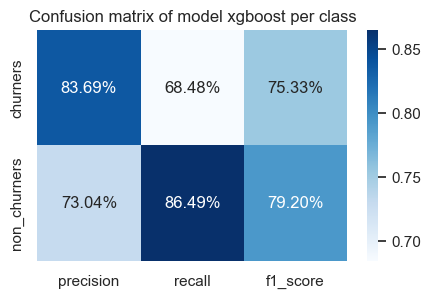

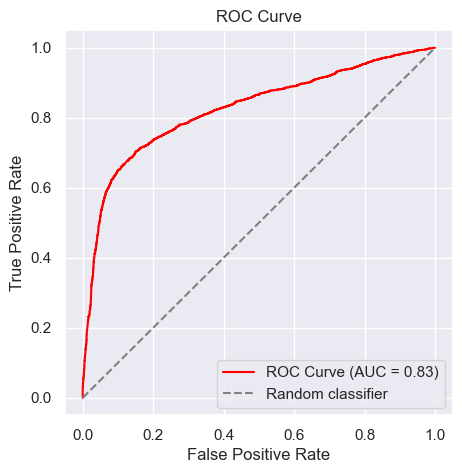

AUTOENCODE 2
                  train set      ||     test set
------------------------------------------------------------
xgboost accuracy    : 0.7860377965789958  ||  0.7715362219558144
xgboost precision   : 0.8513093404285114  ||  0.8392554991539763
xgboost recall      : 0.6955606407322654  ||  0.675289312457454
xgboost f1 score    : 0.7655941061645992  ||  0.7483968313843833
-------------------------------------------------------------


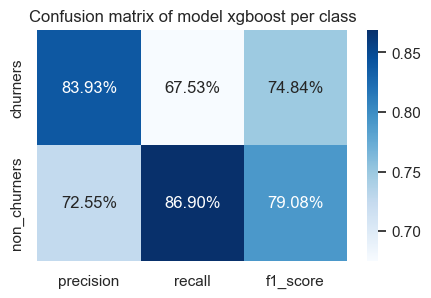

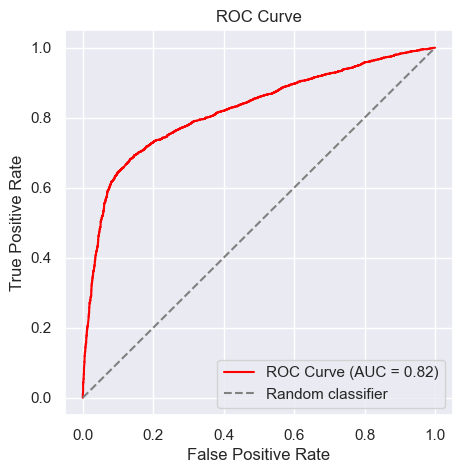

AUTOENCODE 3
                  train set      ||     test set
------------------------------------------------------------
xgboost accuracy    : 0.7898427441603826  ||  0.7765028258263401
xgboost precision   : 0.8516407503735266  ||  0.8392189447444952
xgboost recall      : 0.7043478260869566  ||  0.6875425459496256
xgboost f1 score    : 0.7710227699706921  ||  0.7558465855940131
-------------------------------------------------------------


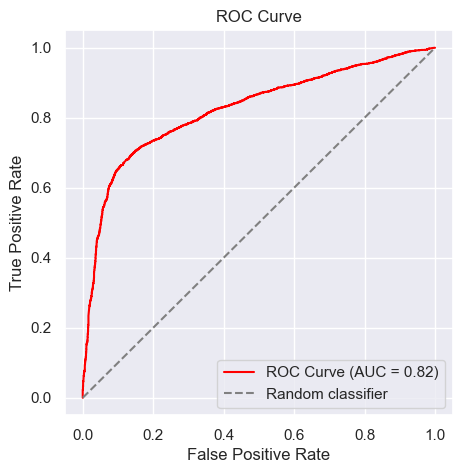

In [183]:
print("AUTOENCODE 1")
y_test_pred_1 = evaluate_xgboost(XGB_MODEL_1, encoded_train_data_1, encoded_test_data_1, y_train_tensor, y_test_tensor)
print("AUTOENCODE 2")
y_test_pred_2 = evaluate_xgboost(XGB_MODEL_2, encoded_train_data_2, encoded_test_data_2, y_train_tensor, y_test_tensor)
print("AUTOENCODE 3")
y_test_pred_3 = evaluate_xgboost(XGB_MODEL_3, encoded_train_data_3, encoded_test_data_3, y_train_tensor, y_test_tensor)

In [184]:
def plot_encoded_data_with_tsne(encoded_test_data, y_test, y_test_pred):
    #Apply tsne for data distribution visualization
    data_tsne = TSNE(n_components = 2, perplexity = 120).fit_transform(encoded_test_data)
    data_tsne = pd.DataFrame(data_tsne, columns = ["x1", "x2"])
    data_tsne["churn"] = y_test
    data_tsne["churn_predicted"] = y_test_pred

    #Plot
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10*2, 8))
    #Plot
    print ("Ploting data distribution")
    sns.set_theme()
    sns.scatterplot(data = data_tsne, x="x1", y="x2", hue = "churn", ax=axes[0], palette=["lightgreen", "red"])
    axes[0].set_title("Perplexity 120 TSNE data distribution of actual target")
    sns.scatterplot(data = data_tsne, x="x1", y="x2", hue = "churn_predicted", ax=axes[1], palette=["lightgreen", "red"])
    axes[1].set_title("Perplexity 120 TSNE data distribution of predicted target")
    plt.show()

Encoded data 1 with AUTOENCODER 1
Ploting data distribution


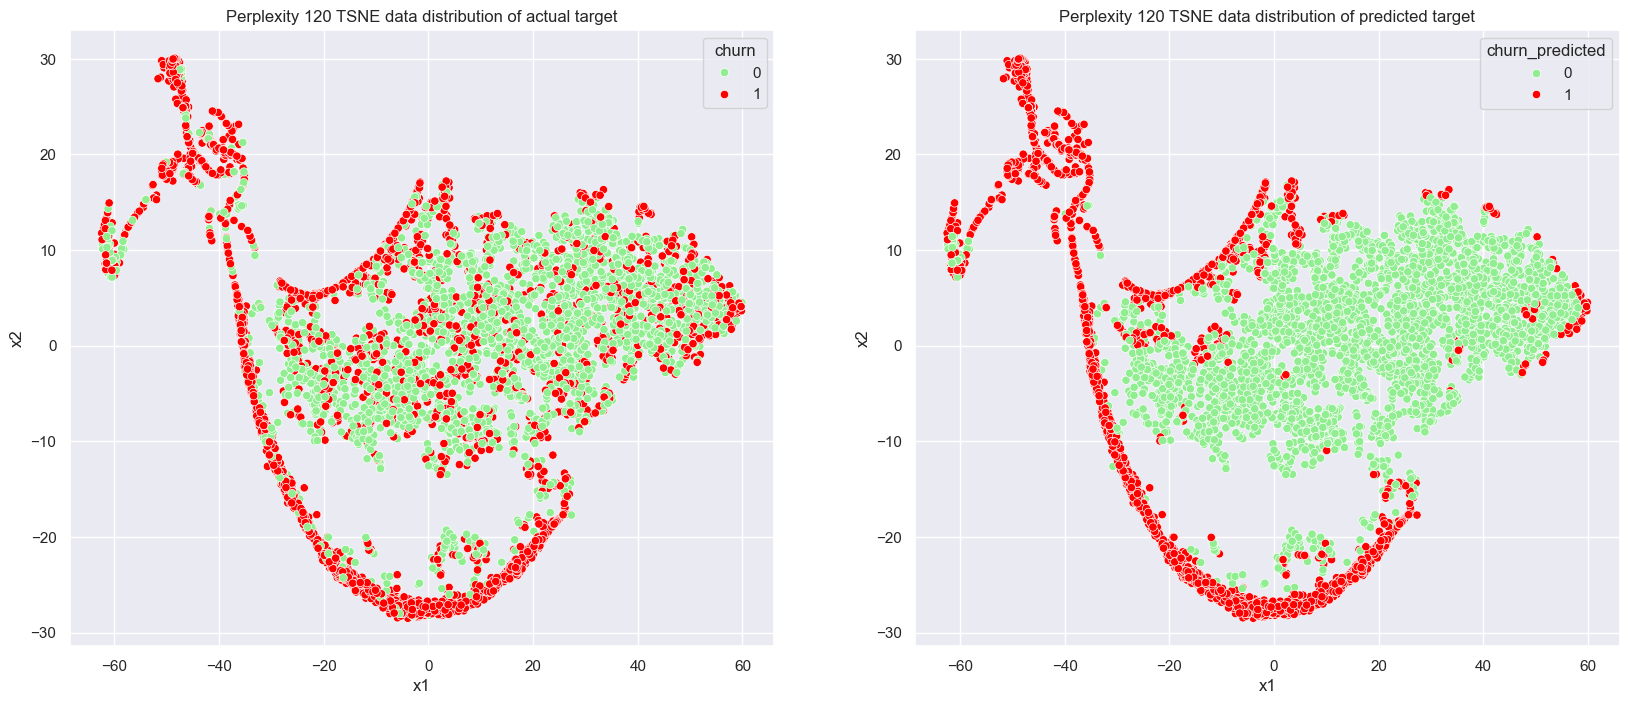

Encoded data 2 with AUTOENCODER 2
Ploting data distribution


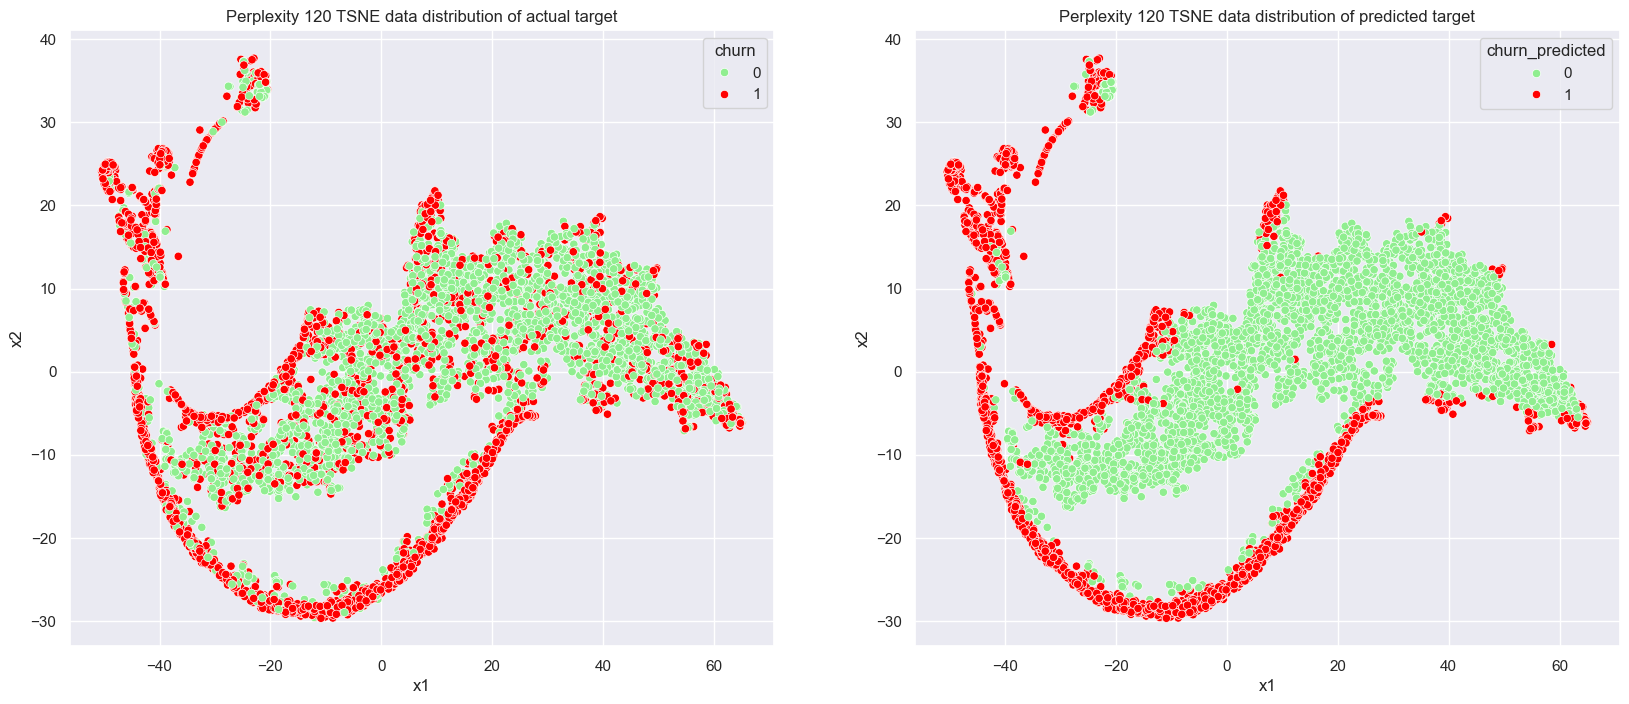

Encoded data 3 with AUTOENCODER 3
Ploting data distribution


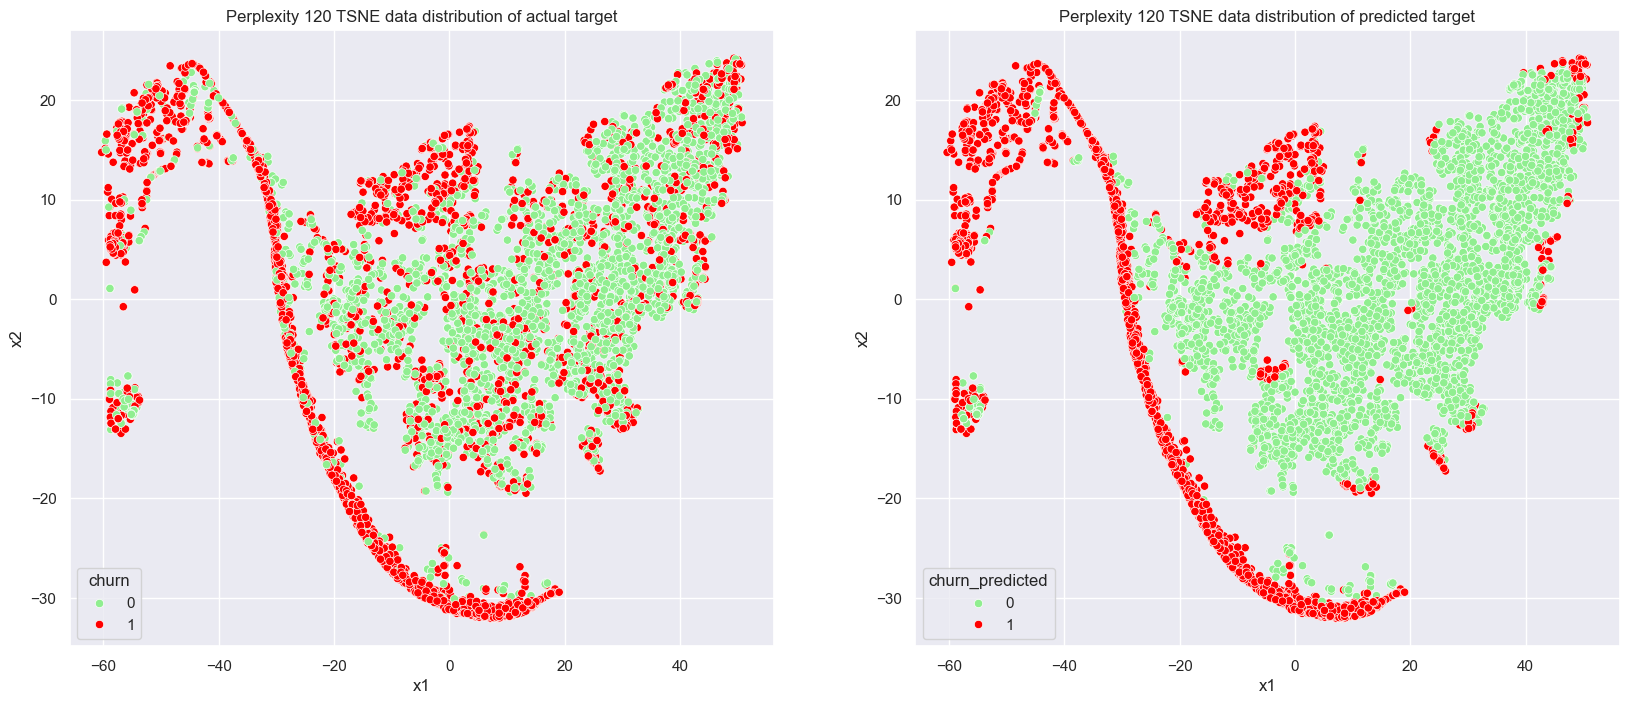

In [185]:
print ("Encoded data 1 with AUTOENCODER 1")
plot_encoded_data_with_tsne(encoded_test_data_1, y_test, y_test_pred_1)
print ("Encoded data 2 with AUTOENCODER 2")
plot_encoded_data_with_tsne(encoded_test_data_2, y_test, y_test_pred_2)
print ("Encoded data 3 with AUTOENCODER 3")
plot_encoded_data_with_tsne(encoded_test_data_3, y_test, y_test_pred_3)

### Check original data and denoised data

In [31]:
utils.vis_tsne_data_distribution(data=x_test, target=y_test, perplexity=120, figsize=(8, 6), palette=["lightgreen", "red"])

Applying tsne on data
Ploting data distribution


### Run this cell if kernel crashes when training the autoencoder

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Step 1: Simulate some sample data for F1, F2, and F3
# We simulate 1000 samples
np.random.seed(0)
F1 = np.random.normal(10, 2, 1000)  # mean=10, std=2
F2 = np.random.normal(20, 5, 1000)  # mean=20, std=5
F3 = np.random.normal(30, 1, 1000)  # mean=30, std=1

# Stack them into a dataset
data = np.stack([F1, F2, F3], axis=1)
data = torch.tensor(data, dtype=torch.float32)

# Step 2: Add artificial noise to create noisy data for training
noise = 0.5 * torch.randn(data.size())
noisy_data = data + noise

# Step 3: Define a simple denoising autoencoder model
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(3, 2),  # Reducing from 3 to 2 dimensions
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 3)  # Reconstructing back to original 3 dimensions
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize the model, loss function, and optimizer
model = DenoisingAutoencoder()
criterion = nn.MSELoss()  # Mean Squared Error loss for reconstruction
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 4: Train the autoencoder
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    output = model(noisy_data)
    loss = criterion(output, data)  # Compare output to original, clean data
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print the loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')